In [1]:
import numpy as np
from PIL import Image
import time, re, os, sys
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import pdist,squareform
from array2gif import write_gif

In [2]:
CLUSTER_NUM=3

In [3]:
GIF_path = '.\GIF'
colormap= np.random.choice(range(256),size=(100,3))

In [4]:
def openImage(path):
    image = cv2.imread(path)
    H, W, C = image.shape
    image_flat = np.zeros((W * H, C))
    for h in range(H):
        image_flat[h * W:(h + 1) * W] = image[h]

    return image_flat,H,W

In [5]:
def precomputed_kernel(X, gamma_s, gamma_c):
    n=len(X)
    # S(x) spacial information
    S=np.zeros((n,2))
    for i in range(n):
        S[i]=[i//100,i%100]
    print(pdist(S,'sqeuclidean').shape)
    K=squareform(np.exp(-gamma_s*pdist(S,'sqeuclidean')))*squareform(np.exp(-gamma_c*pdist(X,'sqeuclidean')))
    print(K.shape)
    return K

In [6]:
def visualize(C,k,H,W):
    '''
    @param C: (10000) belonging classes ndarray
    @param k: #clusters
    @param H: image_H
    @param W: image_W
    @return : (H,W,3) ndarray
    '''
    colors= colormap[:k,:]
    res=np.zeros((H,W,3))
    for h in range(H):
        for w in range(W):
            res[h,w,:] = colors[C[h*W+w]]

    return res.astype(np.uint8)

In [7]:
def kmeans(CLUSTER_NUM, Gram, H, W, init='None'):
    Cluster = np.zeros((CLUSTER_NUM, Gram.shape[1]))
    if init == 'random':
        random_pick=np.random.randint(low=0,high=Gram.shape[0],size=CLUSTER_NUM)
        Cluster = Gram[random_pick,:]
    if init == 'gaussian':
        X_mean=np.mean(Gram,axis=0)
        X_std=np.std(Gram,axis=0)
        for c in range(Gram.shape[1]):
            Cluster[:,c]=np.random.normal(X_mean[c],X_std[c],size=CLUSTER_NUM)
      
    # kmeans++ init
    
    Cluster[0]=Gram[np.random.randint(low=0,high=Gram.shape[0],size=1),:]
    for c in range(1,CLUSTER_NUM):
            Dist=np.zeros((len(Gram),c))
            for i in range(len(Gram)):
                for j in range(c):
                    Dist[i,j]=np.sqrt(np.sum((Gram[i]-Cluster[j])**2))
            Dist_min=np.min(Dist,axis=1)
            sum=np.sum(Dist_min)*np.random.rand()
            for i in range(len(Gram)):
                sum-=Dist_min[i]
                if sum<=0:
                    Cluster[c]=Gram[i]
                    break
    # kmeans++
    diff = 1e9
    eps = 1e-9
    count = 1
    # Classes of each Xi
    C=np.zeros(len(Gram),dtype=np.uint8)
    segments=[]
    while diff > eps:
        # E-step
        for i in range(len(Gram)):
            dist=[]
            for j in range(CLUSTER_NUM):
                dist.append(np.sqrt(np.sum((Gram[i]-Cluster[j])**2)))
            C[i]=np.argmin(dist)
        
        #M-step
        New_Mean=np.zeros(Cluster.shape)
        for i in range(CLUSTER_NUM):
            belong=np.argwhere(C==i).reshape(-1)
            for j in belong:
                New_Mean[i]=New_Mean[i]+Gram[j]
            if len(belong)>0:
                New_Mean[i]=New_Mean[i]/len(belong)

        diff = np.sum((New_Mean - Cluster)**2)
        Cluster=New_Mean
        # visualize
        segment = visualize(C, CLUSTER_NUM, H, W)
        segments.append(segment)
        print('iteration {}'.format(count))
        for i in range(CLUSTER_NUM):
            print('k={}: {}'.format(i + 1, np.count_nonzero(C == i)))
        print('diff {}'.format(diff))
        print('-------------------')
        cv2.imshow('', segment)
        cv2.waitKey(1)
    return C, segments

In [8]:

def plot_eigenvector(xs,ys,zs,C):
    '''
    only for 3-dim datas
    @param xs: (#datapoint) ndarray
    @param ys: (#datapoint) ndarray
    @param zs: (#datapoint) ndarray
    @param C: (#datapoint) ndarray, belonging class
    '''
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    markers=['o','^','s']
    for marker,i in zip(markers,np.arange(3)):
        ax.scatter(xs[C==i],ys[C==i],zs[C==i],marker=marker)

    ax.set_xlabel('eigenvector 1st dim')
    ax.set_ylabel('eigenvector 2nd dim')
    ax.set_zlabel('eigenvector 3rd dim')
    plt.show()

In [9]:
def spectral_clustering(path, cut):
    image_flat,H,Width=openImage(path)
    gamma_s=0.001
    gamma_c=0.001
    k_means_initType='k_means_plusplus'
    k=3  # k clusters
    filename = path.split('.')[0] + '_' + cut + '.gif'
    gif_path = os.path.join(GIF_path, filename)
    # Similarity matrix
    W=precomputed_kernel(image_flat,gamma_s,gamma_c)
    # Degree matrix
    D=np.diag(np.sum(W,axis=1))
    # Graph Laplacian matrix
    L=D-W
    if cut == 'ratio':
        eigenvalue,eigenvector=np.linalg.eig(L)
        try: 
            np.save('{}_eigenvalue_{:.3f}_{:.3f}_unnormalized'.format(path.split('.')[0],gamma_s,gamma_c),eigenvalue)
            np.save('{}_eigenvector_{:.3f}_{:.3f}_unnormalized'.format(path.split('.')[0],gamma_s,gamma_c),eigenvector)
        except:
            print('filed unsaved')
    if cut == 'normalized':
        D_inverse_square_root=np.diag(1/np.diag(np.sqrt(D)))
        L_sym=D_inverse_square_root@L@D_inverse_square_root
        eigenvalue,eigenvector=np.linalg.eig(L_sym)
        try:
            np.save('{}_eigenvalue_{:.3f}_{:.3f}_normalized'.format(path.split('.')[0],gamma_s,gamma_c),eigenvalue)
            np.save('{}_eigenvector_{:.3f}_{:.3f}_normalized'.format(path.split('.')[0],gamma_s,gamma_c),eigenvector)  
        except:
            print('filed unsaved')
    print('goint to sort eigenvalue')
    sort_index = np.argsort(eigenvalue)
    U = eigenvector[:, sort_index[1:1+k]]
    print('eigenvector has been calculated')
    if cut == 'normalized':
        sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
        U_norm=U/sums
        C, segments = kmeans(k, U_norm, H, Width, init='random')
    else:
        C, segments = kmeans(k, U, H, Width, init='random')
    # save_gif
    for i in range(len(segments)):
        segments[i] = segments[i].transpose(1, 0, 2)
    write_gif(segments, gif_path, fps=2)
    if k==3:
        plot_eigenvector(U[:,0],U[:,1],U[:,2],C)
    print('gif is printing')
#     cv2.waitKey(0)
    cv2.destroyAllWindows()
    print('done')

In [10]:

# def spectral_clustering(path, cut):
#     image_flat,H,Width=openImage(path)
#     gamma_s=0.001
#     gamma_c=0.001
#     k_means_initType='k_means_plusplus'
#     k=CLUSTER_NUM
#     filename = path.split('.')[0] + '_' + cut + '.gif'
#     gif_path = os.path.join(GIF_path, filename)
#     W=precomputed_kernel(image_flat,gamma_s,gamma_c)
#     # degree matrix
#     D=np.diag(np.sum(W,axis=1))
#     L=D-W
#     if cut == 'ratio':
#         eigenvalue=np.load('{}_eigenvalue_{:.3f}_{:.3f}_unnormalized.npy'.format(path.split('.')[0],gamma_s,gamma_c))
#         eigenvector=np.load('{}_eigenvector_{:.3f}_{:.3f}_unnormalized.npy'.format(path.split('.')[0],gamma_s,gamma_c))
#     if cut == 'normalized':
#         D_inverse_square_root=np.diag(1/np.diag(np.sqrt(D)))
#         L_sym=D_inverse_square_root@L@D_inverse_square_root
#         eigenvalue=np.load('{}_eigenvalue_{:.3f}_{:.3f}_normalized.npy'.format(path.split('.')[0],gamma_s,gamma_c))
#         eigenvector=np.load('{}_eigenvector_{:.3f}_{:.3f}_normalized.npy'.format(path.split('.')[0],gamma_s,gamma_c))
#     sort_index = np.argsort(eigenvalue)
#     U = eigenvector[:, sort_index[1:1+k]]
#     if cut == 'normalized':
#         sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
#         U_norm=U/sums
#         C, segments = kmeans(CLUSTER_NUM, U_norm, H, Width, init='random')
#     else:
#         C, segments = kmeans(CLUSTER_NUM, U, H, Width, init='random')
#     # save_gif
#     for i in range(len(segments)):
#         segments[i] = segments[i].transpose(1, 0, 2)
#     write_gif(segments, gif_path, fps=2)
#     if CLUSTER_NUM==3:
#         plot_eigenvector(U[:,0],U[:,1],U[:,2],C)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     print('done')


(49995000,)
(10000, 10000)
goint to sort eigenvalue
eigenvector has been calculated
iteration 1
k=1: 3383
k=2: 5510
k=3: 1107
diff 1.0749949204242344e-06
-------------------
iteration 1
k=1: 3388
k=2: 5505
k=3: 1107
diff 3.437851645818115e-10
-------------------


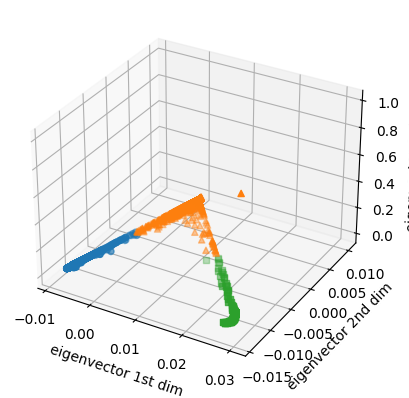

gif is printing
done
(49995000,)
(10000, 10000)
goint to sort eigenvalue
eigenvector has been calculated
iteration 1
k=1: 2881
k=2: 5238
k=3: 1881
diff 0.4630949784446329
-------------------
iteration 1
k=1: 3012
k=2: 5277
k=3: 1711
diff 0.007666360116967155
-------------------
iteration 1
k=1: 3212
k=2: 5294
k=3: 1494
diff 0.01544591313377605
-------------------
iteration 1
k=1: 3379
k=2: 5296
k=3: 1325
diff 0.012044849506543137
-------------------
iteration 1
k=1: 3468
k=2: 5301
k=3: 1231
diff 0.004362316188416002
-------------------
iteration 1
k=1: 3516
k=2: 5302
k=3: 1182
diff 0.0012423810981551963
-------------------
iteration 1
k=1: 3523
k=2: 5305
k=3: 1172
diff 5.4120013117023727e-05
-------------------
iteration 1
k=1: 3524
k=2: 5305
k=3: 1171
diff 5.027774719843656e-07
-------------------
iteration 1
k=1: 3524
k=2: 5305
k=3: 1171
diff 0.0
-------------------


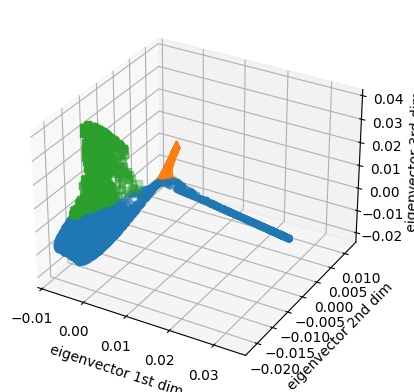

gif is printing
done
(49995000,)
(10000, 10000)
goint to sort eigenvalue
eigenvector has been calculated
iteration 1
k=1: 3825
k=2: 4119
k=3: 2056
diff 0.00016911464047324204
-------------------
iteration 1
k=1: 3571
k=2: 2980
k=3: 3449
diff 2.5401984150556262e-05
-------------------
iteration 1
k=1: 3553
k=2: 2531
k=3: 3916
diff 5.409616445664914e-06
-------------------
iteration 1
k=1: 3562
k=2: 2366
k=3: 4072
diff 8.132935522073906e-07
-------------------
iteration 1
k=1: 3566
k=2: 2314
k=3: 4120
diff 8.174748453559647e-08
-------------------
iteration 1
k=1: 3566
k=2: 2286
k=3: 4148
diff 2.357031998761333e-08
-------------------
iteration 1
k=1: 3566
k=2: 2279
k=3: 4155
diff 1.4832301884667654e-09
-------------------
iteration 1
k=1: 3567
k=2: 2276
k=3: 4157
diff 2.964926943531034e-10
-------------------


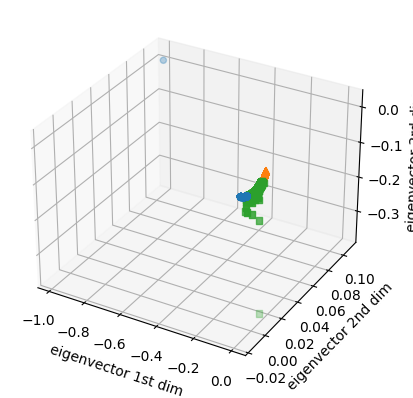

gif is printing
done
(49995000,)
(10000, 10000)
goint to sort eigenvalue
eigenvector has been calculated
iteration 1
k=1: 3392
k=2: 1804
k=3: 4804
diff 1.0718894039268074
-------------------
iteration 1
k=1: 3434
k=2: 3052
k=3: 3514
diff 0.1760472394662569
-------------------
iteration 1
k=1: 3482
k=2: 3712
k=3: 2806
diff 0.06685477270165438
-------------------
iteration 1
k=1: 3579
k=2: 3930
k=3: 2491
diff 0.019306219614364992
-------------------
iteration 1
k=1: 3630
k=2: 3996
k=3: 2374
diff 0.0030494457258616815
-------------------
iteration 1
k=1: 3654
k=2: 4006
k=3: 2340
diff 0.00032668425323893844
-------------------
iteration 1
k=1: 3662
k=2: 4009
k=3: 2329
diff 3.465005130569331e-05
-------------------
iteration 1
k=1: 3663
k=2: 4010
k=3: 2327
diff 9.172960898996767e-07
-------------------
iteration 1
k=1: 3664
k=2: 4010
k=3: 2326
diff 3.738337461579915e-07
-------------------
iteration 1
k=1: 3665
k=2: 4009
k=3: 2326
diff 1.5833181605644864e-07
-------------------
iteration 1


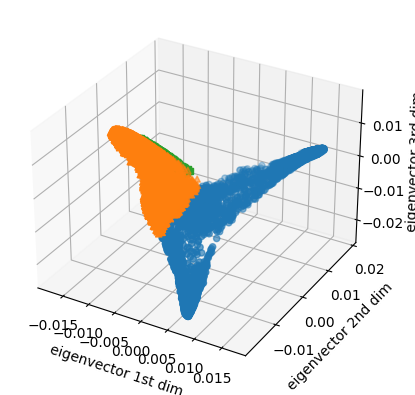

gif is printing
done


In [11]:
spectral_clustering('image1.png', 'ratio')
spectral_clustering('image1.png', 'normalized')
spectral_clustering('image2.png', 'ratio')
spectral_clustering('image2.png', 'normalized')